In [34]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import uniform, randint

df = pd.read_csv('./data/fixed-text_CMU.csv')
df['subject'] = df['subject'].str.replace('s','').astype(int)
# df = df.drop(['sessionIndex', 'rep'], axis = 1

Subject = df['subject'].unique()

# Test / Train data

In [35]:
# Define the genuine user's subject ID
# for 문으로 변경 가능

# genuine_subject = 19

def split_data(df, genuine_subject):
    train_features_genuine = pd.DataFrame()
    train_label_genuine = pd.Series(dtype=int)

    train_features_genuine = pd.concat([train_features_genuine, 
                                        df[(df['subject'] == genuine_subject) & (df['sessionIndex'] <= 4)].drop(['sessionIndex', 'rep', 'subject'], axis=1)])
    train_label_genuine = pd.concat([train_label_genuine,
                                        df[(df['subject'] == genuine_subject) & (df['sessionIndex'] <= 4)]['subject']])

    # Initialize empty DataFrames and Series
    test_features_genuine = pd.DataFrame()
    test_features_impostor = pd.DataFrame()
    test_label_genuine = pd.Series(dtype=int)
    test_label_impostor = pd.Series(dtype=int)

    # Iterate over unique subjects
    for user in df['subject'].unique():
        if user == genuine_subject:
            test_features_genuine = pd.concat([test_features_genuine, 
                                        df[(df['subject'] == genuine_subject) & (df['sessionIndex'] > 4)].drop(['sessionIndex', 'rep', 'subject'], axis=1)])
            test_label_genuine = pd.concat([test_label_genuine, 
                                    df[(df['subject'] == genuine_subject) & (df['sessionIndex'] > 4)]['subject']])
        else:
            test_features_impostor = pd.concat([test_features_impostor, 
                                        df[(df['subject'] == user) & (df['sessionIndex'] == 1) & (df['rep'] <= 5)].drop(['sessionIndex', 'rep', 'subject'], axis=1)])
            test_label_impostor = pd.concat([test_label_impostor, 
                                        df[(df['subject'] == user) & (df['sessionIndex'] == 1) & (df['rep'] <= 5)]['subject']])
            
    # Reset the index of the DataFrames
    # train_features_genuine.reset_index(drop=True, inplace=True)
    # test_features_genuine.reset_index(drop=True, inplace=True)
    # test_features_impostor.reset_index(drop=True, inplace=True)
    # train_label_genuine.reset_index(drop=True, inplace=True)

    # Check for NaN or infinite values in the training data
    assert not train_features_genuine.isnull().values.any(), "Training data contains NaN values"
    assert np.isfinite(train_features_genuine.values).all(), "Training data contains infinite values"

    assert not test_features_genuine.isnull().values.any(), "Genuine test data contains NaN values"
    assert np.isfinite(test_features_genuine.values).all(), "Test data contains infinite values"

    assert not test_features_impostor.isnull().values.any(), "Impostor test data contains NaN values"
    assert np.isfinite(test_features_impostor.values).all(), "Test data contains infinite values"

    return train_features_genuine, train_label_genuine, test_features_genuine, test_label_genuine, test_features_impostor, test_label_impostor

def normalizing_distance(user_scores, impostor_scores):
    # Normalize the distances to [0, 1]
    scaler = MinMaxScaler()
    all_scores = np.array(user_scores + impostor_scores).reshape(-1, 1)
    all_scores_normalized = scaler.fit_transform(all_scores)

    # Split the normalized scores back into user and impostor scores
    user_scores_normalized = all_scores_normalized[:len(user_scores)].flatten()
    impostor_scores_normalized = all_scores_normalized[len(user_scores):].flatten()

    return user_scores_normalized, impostor_scores_normalized

# Nearest neighborhood (Mahalanobis)

In [36]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import mahalanobis


def nearest_neighbor_mahalanobis(
        train_features_genuine, train_label_genuine,
        test_features_genuine, test_label_genuine,
        test_features_impostor, test_label_impostor):
    
    # Calculate the covariance matrix
    cov_matrix = np.cov(train_features_genuine, rowvar=False)
    regularization_value = 1e-8
    cov_matrix += np.eye(cov_matrix.shape[0]) * regularization_value

    inv_cov_matrix = np.linalg.inv(cov_matrix)

    # Calculate the Mahalanobis distance
    def mahalanobis_distance(u, v, VI):
        return mahalanobis(u, v, VI)

    model = NearestNeighbors(n_neighbors=1, metric=mahalanobis_distance, metric_params={'VI': inv_cov_matrix})
    model.fit(train_features_genuine)

    # # Calculate the Mahalanobis distance for genuine user
    user_scores = []
    for i in range(test_features_genuine.shape[0]):
        test_point = test_features_genuine.iloc[i].values.reshape(1, -1)
        test_point_df = pd.DataFrame(test_point, columns=train_features_genuine.columns)
        distance, index = model.kneighbors(test_point_df)
        user_scores.append(distance[0][0])

    # Calculate the Mahalanobis distance for impostor user
    impostor_scores = []
    for i in range(test_features_impostor.shape[0]):
        test_point = test_features_impostor.iloc[i].values.reshape(1, -1)
        test_point_df = pd.DataFrame(test_point, columns=train_features_genuine.columns)
        distance, index = model.kneighbors(test_point_df)
        impostor_scores.append(distance[0][0])

    return user_scores, impostor_scores

# Manhattan (scaled)

In [43]:
# Manhattan distance (scaled)

def ManhattanScaled(
        train_features_genuine, train_label_genuine,
        test_features_genuine, test_label_genuine,
        test_features_impostor, test_label_impostor):
    
    features_columns = train_features_genuine.columns

    train_mean_vector = train_features_genuine[features_columns].mean()
    train_mad_vector = (train_features_genuine[features_columns].subtract(train_mean_vector).abs()).mean()

    # Calculate the Manhattan distance (scaled) for genuine user
    user_scores = []
    user_distances = test_features_genuine[features_columns].subtract(train_mean_vector).abs().divide(train_mad_vector).sum(axis=1)
    user_scores = user_distances.tolist()

    # Calculate the Manhattan distance (scaled) for impostor user
    impostor_scores = []
    impostor_distances = test_features_impostor[features_columns].subtract(train_mean_vector).abs().divide(train_mad_vector).sum(axis=1)
    impostor_scores = impostor_distances.tolist()

    return user_scores, impostor_scores

# Evaluation

In [37]:
def calculate_equal_error(user_scores, impostor_scores):
    # Combine the scores and create labels
    predictions = np.concatenate((user_scores, impostor_scores))
    labels = np.concatenate((np.zeros(len(user_scores)), np.ones(len(impostor_scores))))
    
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(labels, predictions, pos_label=1)

    # Calculate the EER
    fnr = 1 - tpr
    index_threshold = np.nanargmin(np.abs(fpr - fnr))
    eer_threshold = thresholds[index_threshold]
    eer = fpr[index_threshold]

    return eer

def calculate_zero_miss_rate(user_scores, impostor_scores):
    # Combine the scores and create labels
    predictions = np.concatenate((user_scores, impostor_scores))
    labels = np.concatenate((np.zeros(len(user_scores)), np.ones(len(impostor_scores))))
    
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(labels, predictions, pos_label=1)

    # Calculate the EER
    fnr = 1 - tpr
    index_threshold = np.nanargmin(np.abs(fpr - fnr))
    eer_threshold = thresholds[index_threshold]
    eer = fpr[index_threshold]

    # Find the point for zero miss rate (false negative rate is zero)
    zero_miss_rate_index = np.where(fnr == 0)[0][0]

    # Calculate the zero miss rate
    zero_miss_rate = fpr[zero_miss_rate_index]
    
    return zero_miss_rate

In [38]:
calculate_zero_miss_rate(*normalizing_distance(*nearest_neighbor_mahalanobis(*split_data(df, 19))))

0.175

# Average EER and ZMR by nearest_neighbor_mahalanobis

In [225]:
# # Calculate the Equal Error Rate (EER)
# eer = calculate_equal_error(*nearest_neighbor_mahalanobis(*split_data(df, 19)))
# print(f"Equal Error Rate (EER): {eer}")

# # Calculate the Zero Miss Rate
# zero_miss_rate = calculate_zero_miss_rate(*nearest_neighbor_mahalanobis(*split_data(df, 19)))
# print(f"Zero Miss Rate: {zero_miss_rate}")

ls_eer = []
ls_zmr = []

for subject in Subject:
    # print(f"Subject: {subject}")
    eer = calculate_equal_error(*normalizing_distance(*nearest_neighbor_mahalanobis(*split_data(df, subject))))
    ls_eer.append(eer)
    # print(f"Equal Error Rate (EER): {eer}")
    zero_miss_rate = calculate_zero_miss_rate(*normalizing_distance(*nearest_neighbor_mahalanobis(*split_data(df, subject))))
    ls_zmr.append(zero_miss_rate)
    # print(f"Zero Miss Rate: {zero_miss_rate}")

print(f"Average EER: {np.mean(ls_eer)}")
print(f"Average ZMR: {np.mean(ls_zmr)}")

Average EER: 0.09950980392156865
Average ZMR: 0.4675490196078431


# Average EER and ZMR by manhattan (scaled)

In [44]:
ls_eer = []
ls_zmr = []

for subject in Subject:
    # print(f"Subject: {subject}")
    eer = calculate_equal_error(*normalizing_distance(*ManhattanScaled(*split_data(df, subject))))
    ls_eer.append(eer)
    # print(f"Equal Error Rate (EER): {eer}")
    zero_miss_rate = calculate_zero_miss_rate(*normalizing_distance(*ManhattanScaled(*split_data(df, subject))))
    ls_zmr.append(zero_miss_rate)
    # print(f"Zero Miss Rate: {zero_miss_rate}")

print(f"Average EER: {np.mean(ls_eer)}")
print(f"Average ZMR: {np.mean(ls_zmr)}")

Average EER: 0.09666666666666666
Average ZMR: 0.6007843137254902


# Plot

In [39]:
# Plotting ROC curve

def plot_roc_curve(user_scores, impostor_scores):
    # Combine the scores and create labels
    predictions = np.concatenate((user_scores, impostor_scores))
    labels = np.concatenate((np.zeros(len(user_scores)), np.ones(len(impostor_scores))))
    
    # Calculate false positive rates, true positive rates, and thresholds
    fpr, tpr, thresholds = roc_curve(labels, predictions, pos_label=1)
    
    # Calculate the AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)

    # Find the EER (Equal Error Rate)
    fnr = 1 - tpr  # False negative rate
    index_threshold = np.nanargmin(np.abs(fpr - fnr))
    eer_threshold = thresholds[index_threshold]
    eer = fpr[index_threshold]

    # Find the point for zero miss rate (false negative rate is zero)
    zero_miss_rate_index = np.where(fnr == 0)[0][0]

    # Plot the ROC curve
    fig = plt.figure(figsize=(5, 5))  # Square plot
    ax = fig.add_subplot(111, aspect='equal')
    
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    # Annotate EER
    plt.annotate(f'EER = {eer:.2f}', xy=(fpr[index_threshold], tpr[index_threshold]), xytext=(fpr[index_threshold]+0.1, tpr[index_threshold]-0.1),
                arrowprops=dict(facecolor='black', shrink=0.05))

    # Annotate Zero Miss Rate
    plt.annotate('Zero Miss Rate', xy=(fpr[zero_miss_rate_index], tpr[zero_miss_rate_index]), 
                xytext=(fpr[zero_miss_rate_index]+0.1, tpr[zero_miss_rate_index]-0.1),
                arrowprops=dict(facecolor='blue', shrink=0.05))

    plt.show()


def plot_fpr_frr_curve(user_scores, impostor_scores):
    # Combine the scores and create labels
    predictions = np.concatenate((user_scores, impostor_scores))
    labels = np.concatenate((np.zeros(len(user_scores)), np.ones(len(impostor_scores))))
    
    # Calculate false positive rates, true positive rates, and thresholds
    fpr, tpr, thresholds = roc_curve(labels, predictions, pos_label=1)
    
    # Find the EER (Equal Error Rate)
    fnr = 1 - tpr  # False negative rate
    index_threshold = np.nanargmin(np.abs(fpr - fnr))
    eer_threshold = thresholds[index_threshold]
    eer = fpr[index_threshold]

    # Find the point for zero miss rate (false negative rate is zero)
    zero_miss_rate_index = np.where(fnr == 0)[0][0]

    # plot the FPR-FRR curve
    fig = plt.figure(figsize=(5, 5))  # Square plot
    ax = fig.add_subplot(111, aspect='equal')

    plt.plot(thresholds, fpr, color='blue', lw=2, label='FPR')
    plt.plot(thresholds, fnr, color='red', lw=2, label='FNR')

    # draw EER line
    plt.axhline(y=eer, color='black', linestyle='--', label=f'EER = {eer:.2f}')
    plt.axhline(y=fpr[zero_miss_rate_index], color='green', linestyle='--', label=f'Zero Miss Rate = {fpr[zero_miss_rate_index]:.2f}')

    
    plt.xlabel('Threshold')
    plt.ylabel('Error Rate')
    plt.title('FPR-FNR Curve')
    plt.legend(loc="upper right")

    plt.show()
    

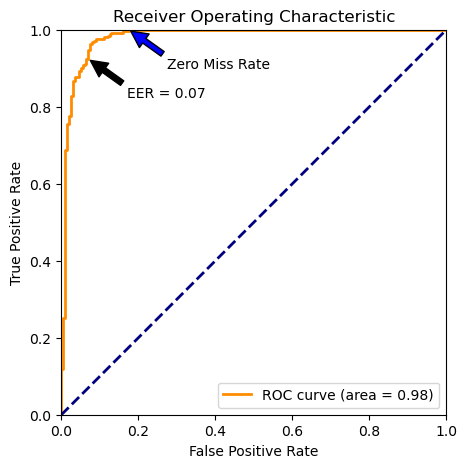

In [40]:
plot_roc_curve(*normalizing_distance(*nearest_neighbor_mahalanobis(*split_data(df, 19))))

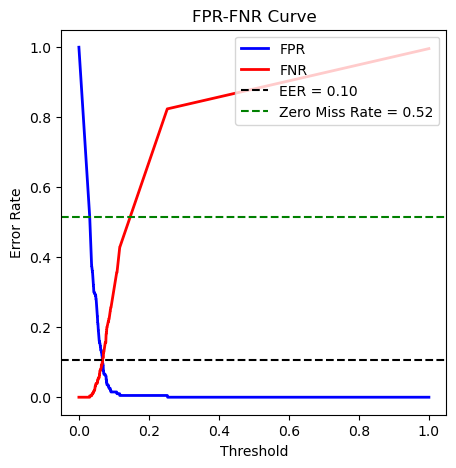

In [41]:
plot_fpr_frr_curve(*normalizing_distance(*nearest_neighbor_mahalanobis(*split_data(df, 21))))